In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import random
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [2]:
size=150
data=[]
assign_dict = {"NORMAL":1, "PNEUMONIA":0}
def load_data(directory):
    for sub_directory in os.listdir(directory):
        if sub_directory=="NORMAL":
            inner_directory=os.path.join(directory,sub_directory)
            for i in os.listdir(inner_directory):
                img=cv2.imread(os.path.join(inner_directory,i),0)
                img=cv2.resize(img,(size,size))
                data.append([img,assign_dict[sub_directory]])
                
        if sub_directory=="PNEUMONIA":
            inner_directory=os.path.join(directory,sub_directory)
            for i in os.listdir(inner_directory):
                img=cv2.imread(os.path.join(inner_directory,i),0)
                img=cv2.resize(img,(size,size))
                data.append([img,assign_dict[sub_directory]])        
            
    random.shuffle(data)
    return np.array(data)

In [3]:
train=load_data('../input/chest-xray-pneumonia/chest_xray/train')
val = load_data('../input/chest-xray-pneumonia/chest_xray/val')
test = load_data('../input/chest-xray-pneumonia/chest_xray/test')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


<AxesSubplot:ylabel='count'>

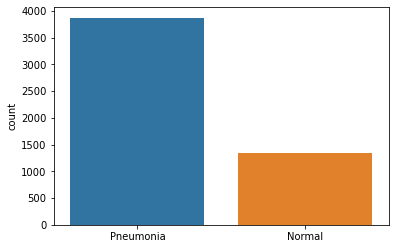

In [4]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.countplot(x = l)

## The dataset is imbalanced thus using data augmentation

In [5]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [6]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [7]:
# resize data for deep learning 
img_size = 150
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [8]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [9]:
model = Sequential()
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape=x_train.shape[1:]))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization(axis=1))

model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization(axis=1))

model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization(axis=1))

model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization(axis=1))

model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())

model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
adam = Adam(learning_rate=0.0001)

model.compile(optimizer = adam,metrics=['acc'] , loss = 'binary_crossentropy' )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 64)        300       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        18464     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 32)        300       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 32)        0

In [10]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [11]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 20 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/20
163/163 [==============================] - 22s 112ms/step - loss: 0.5168 - acc: 0.7791 - val_loss: 0.7026 - val_acc: 0.7422
Epoch 2/20
163/163 [==============================] - 18s 112ms/step - loss: 0.2593 - acc: 0.8872 - val_loss: 0.8997 - val_acc: 0.7422
Epoch 3/20
163/163 [==============================] - 18s 108ms/step - loss: 0.2526 - acc: 0.8951 - val_loss: 0.9605 - val_acc: 0.7422
Epoch 4/20
163/163 [==============================] - 18s 113ms/step - loss: 0.2400 - acc: 0.8945 - val_loss: 0.5322 - val_acc: 0.8008
Epoch 5/20
163/163 [==============================] - 18s 112ms/step - loss: 0.1806 - acc: 0.9272 - val_loss: 0.2958 - val_acc: 0.8698
Epoch 6/20
163/163 [==============================] - 18s 109ms/step - loss: 0.1861 - acc: 0.9234 - val_loss: 0.2077 - val_acc: 0.9163
Epoch 7/20
163/163 [==============================] - 18s 112ms/step - loss: 0.1744 - acc: 0.9297 - val_loss: 0.1683 - val_acc: 0.9377
Epoch 8/20
163/163 [==============================] - 1

In [12]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

183/183 [==============================] - 2s 8ms/step - loss: 0.1330 - acc: 0.9547
Loss of the model is -  0.1329605132341385
183/183 [==============================] - 2s 8ms/step - loss: 0.1330 - acc: 0.9547
Accuracy of the model is -  95.47472596168518 %


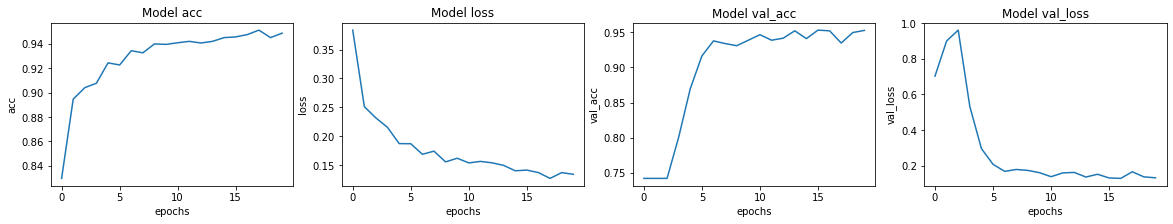

In [13]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()


for i, met in enumerate(['acc', 'loss','val_acc','val_loss']):
    ax[i].plot(history.history[met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)

In [14]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [15]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.97      0.97      0.97      4273
   Normal (Class 1)       0.91      0.92      0.92      1583

           accuracy                           0.95      5856
          macro avg       0.94      0.94      0.94      5856
       weighted avg       0.95      0.95      0.95      5856



<AxesSubplot:>

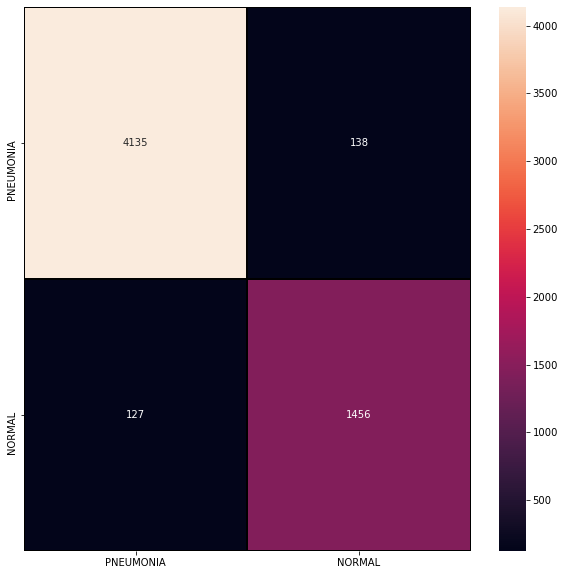

In [16]:
cm = confusion_matrix(y_test,predictions)
plt.figure(figsize = (10,10))
sns.heatmap(cm, linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ['PNEUMONIA', 'NORMAL'], yticklabels =  ['PNEUMONIA', 'NORMAL'])

In [17]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")